In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import mpl

In [2]:
def write2excel(df,savepath,sheet_name):
    """
    将数据写入已存在的 excel 表
    df：DataFrame
    savepath：excel 所在的路径
    sheet_name：表格名
    """
    import openpyxl

    wb = openpyxl.load_workbook(savepath)
    #如果有多个模块可以读写excel文件，这里要指定engine，否则可能会报错
    writer = pd.ExcelWriter(savepath,engine='openpyxl')
    #没有下面这个语句的话excel表将完全被覆盖
    writer.book = wb

    #如果有相同名字的工作表，新添加的将命名为Sheet21，如果Sheet21也有了就命名为Sheet22，不会覆盖原来的工作表
    df.to_excel(writer,sheet_name = sheet_name)
    writer.save()
    writer.close()

In [3]:
# 20220729更新
def df_describe(df):
    """
    得出描述性统计
    :df: 接收 pandas.DataFrame 数据格式
    """      
    des = df.describe().T # 初步的描述性统计结果
    des["CV"] = 100 * des["std"]/ des["mean"] # 计算变异系数
    des = des.drop(["25%","75%"],axis=1) # 删掉四分位点
    
    skew = pd.DataFrame(df.skew(),columns={"skew"}) # 偏度计算
    kurt = pd.DataFrame(df.kurt(),columns={"kurt"}) # 峰度计算
    sk = pd.concat([skew,kurt],axis=1)
    
    des_final = pd.concat([des,sk],axis=1)
    
    des_final.columns = ["样本数","均值","标准差",
                   "最小值","中位数","最大值","变异系数 CV（%）",
                  "偏度","峰度"] # 进行中文命名
    
    return des_final

In [4]:
def data_standard(data):
    """
    标准化数据：减去均值再除以标准差
    data：有 index 的 DataFrame
    """  
    from sklearn.preprocessing import scale
    data_scaled = scale(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns,index=data.index)
    
    return data_scaled

In [5]:
def data_normalize(data):
    """
    标准化数据：减去均值再除以标准差
    data：有 index 的 DataFrame
    """     
    from sklearn.preprocessing import normalize
    data_scaled = normalize(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns,index=data.index)
    
    return data_scaled

## 1 读入原始数据

In [6]:
wd = 'your/work/directory'

In [7]:
# 所有性状
filepath = wd + "filename.xlsx"
data = pd.read_excel(filepath,sheet_name="修正大小写")
data.head(2)

,Compounds,Class,物质分类,ROC22-1,ROC22-2,ROC22-3,ROC16-1,ROC16-2,ROC16-3,F134-1,...,F134-3,F172-1,F172-2,F172-3,YT93159-1,YT93159-2,YT93159-3,YT71210-1,YT71210-2,YT71210-3
0,5H-Tetrazol-5-Amine,Amine,胺,6088.142982,10028.841755,8125.084683,21733.155933,24990.276748,23167.684264,12431.480669,...,11852.455986,7330.185902,5832.763393,5092.870833,11149.371193,9668.379729,11343.914692,30655.593405,30992.053744,30562.354427
1,"N,N'-1,2-ethanediylidenebis-2-PropanAmine",Amine,胺,23657.376886,26180.284192,24874.288652,7557.149957,10054.469483,10508.186507,21190.217620,...,16772.049512,11747.212787,10937.561791,11100.541703,44674.161324,50119.697918,60094.115603,73332.289629,70042.675565,92966.816270


In [8]:
data.shape

(161, 21)

In [9]:
data['Class'].value_counts()

Ester                       28
Aldehyde                    24
Heterocyclic compound       23
Hydrocarbons                23
Ketone                      17
Aromatics                   13
Alcohol                      9
Acid                         7
Other                        5
Amine                        4
Terpenoids                   3
Phenol                       2
Nitrogen compounds           1
Sulfur compounds             1
Halogenated hydrocarbons     1
Name: Class, dtype: int64

## 2 拆分数据为待处理数据/纯数据（只含样本和变量）和映射表

In [10]:
do = data.drop(['Class','物质分类'],axis=1)
do.head(2)

,Compounds,ROC22-1,ROC22-2,ROC22-3,ROC16-1,ROC16-2,ROC16-3,F134-1,F134-2,F134-3,F172-1,F172-2,F172-3,YT93159-1,YT93159-2,YT93159-3,YT71210-1,YT71210-2,YT71210-3
0,5H-Tetrazol-5-Amine,6088.142982,10028.841755,8125.084683,21733.155933,24990.276748,23167.684264,12431.480669,16176.060501,11852.455986,7330.185902,5832.763393,5092.870833,11149.371193,9668.379729,11343.914692,30655.593405,30992.053744,30562.354427
1,"N,N'-1,2-ethanediylidenebis-2-PropanAmine",23657.376886,26180.284192,24874.288652,7557.149957,10054.469483,10508.186507,21190.217620,18070.192664,16772.049512,11747.212787,10937.561791,11100.541703,44674.161324,50119.697918,60094.115603,73332.289629,70042.675565,92966.816270


In [11]:
do = do.set_index('Compounds')
do.head(2)

,ROC22-1,ROC22-2,ROC22-3,ROC16-1,ROC16-2,ROC16-3,F134-1,F134-2,F134-3,F172-1,F172-2,F172-3,YT93159-1,YT93159-2,YT93159-3,YT71210-1,YT71210-2,YT71210-3
Compounds,,,,,,,,,,,,,,,,,,
5H-Tetrazol-5-Amine,6088.142982,10028.841755,8125.084683,21733.155933,24990.276748,23167.684264,12431.480669,16176.060501,11852.455986,7330.185902,5832.763393,5092.870833,11149.371193,9668.379729,11343.914692,30655.593405,30992.053744,30562.354427
"N,N'-1,2-ethanediylidenebis-2-PropanAmine",23657.376886,26180.284192,24874.288652,7557.149957,10054.469483,10508.186507,21190.217620,18070.192664,16772.049512,11747.212787,10937.561791,11100.541703,44674.161324,50119.697918,60094.115603,73332.289629,70042.675565,92966.816270


In [12]:
dmap = data.iloc[:,:3]
dmap.head(2)

,Compounds,Class,物质分类
0,5H-Tetrazol-5-Amine,Amine,胺
1,"N,N'-1,2-ethanediylidenebis-2-PropanAmine",Amine,胺


In [13]:
# 查看描述性统计
do_desc = df_describe(do.T)
do_desc.head(2)

,样本数,均值,标准差,最小值,中位数,最大值,变异系数 CV（%）,偏度,峰度
Compounds,,,,,,,,,
5H-Tetrazol-5-Amine,18.0,15401.148380,9135.925405,5092.870833,11598.185339,30992.053744,59.319767,0.709985,-1.004316
"N,N'-1,2-ethanediylidenebis-2-PropanAmine",18.0,32437.738226,26207.224020,7557.149957,22423.797253,92966.816270,80.792390,1.090416,0.034620


In [14]:
savepath = wd + "filename.xlsx"
sheet_name = "desc"
write2excel(do_desc,savepath,sheet_name)

## 3 正则化纯数据

In [15]:
do_n = data_normalize(do) # 正则化

In [16]:
savepath = wd + "filename.xlsx"
sheet_name = "数据正则化"
write2excel(do_n,savepath,sheet_name)

## 4 做样本方向和变量方向（转置）的聚类图

In [17]:
def plot_dend(data_scaled,savepath):
    """
    绘制层次聚类图
    data_scaled：index 是经过正则化或标准化的数据
    savepath：图片保存的路径
    """
    import scipy.cluster.hierarchy as shc
    plt.figure(figsize=(30, 7))  
    Z = shc.linkage(data_scaled,method='ward',metric='euclidean') 
    dend = shc.dendrogram(Z,labels=data_scaled.index)

    plt.xticks(fontsize=12)
#     plt.xticks(rotation=60)
    # plt.axhline(y=5.5, color='r', linestyle='--') # 画一条横线
    plt.savefig(savepath,bbox_inches = 'tight')

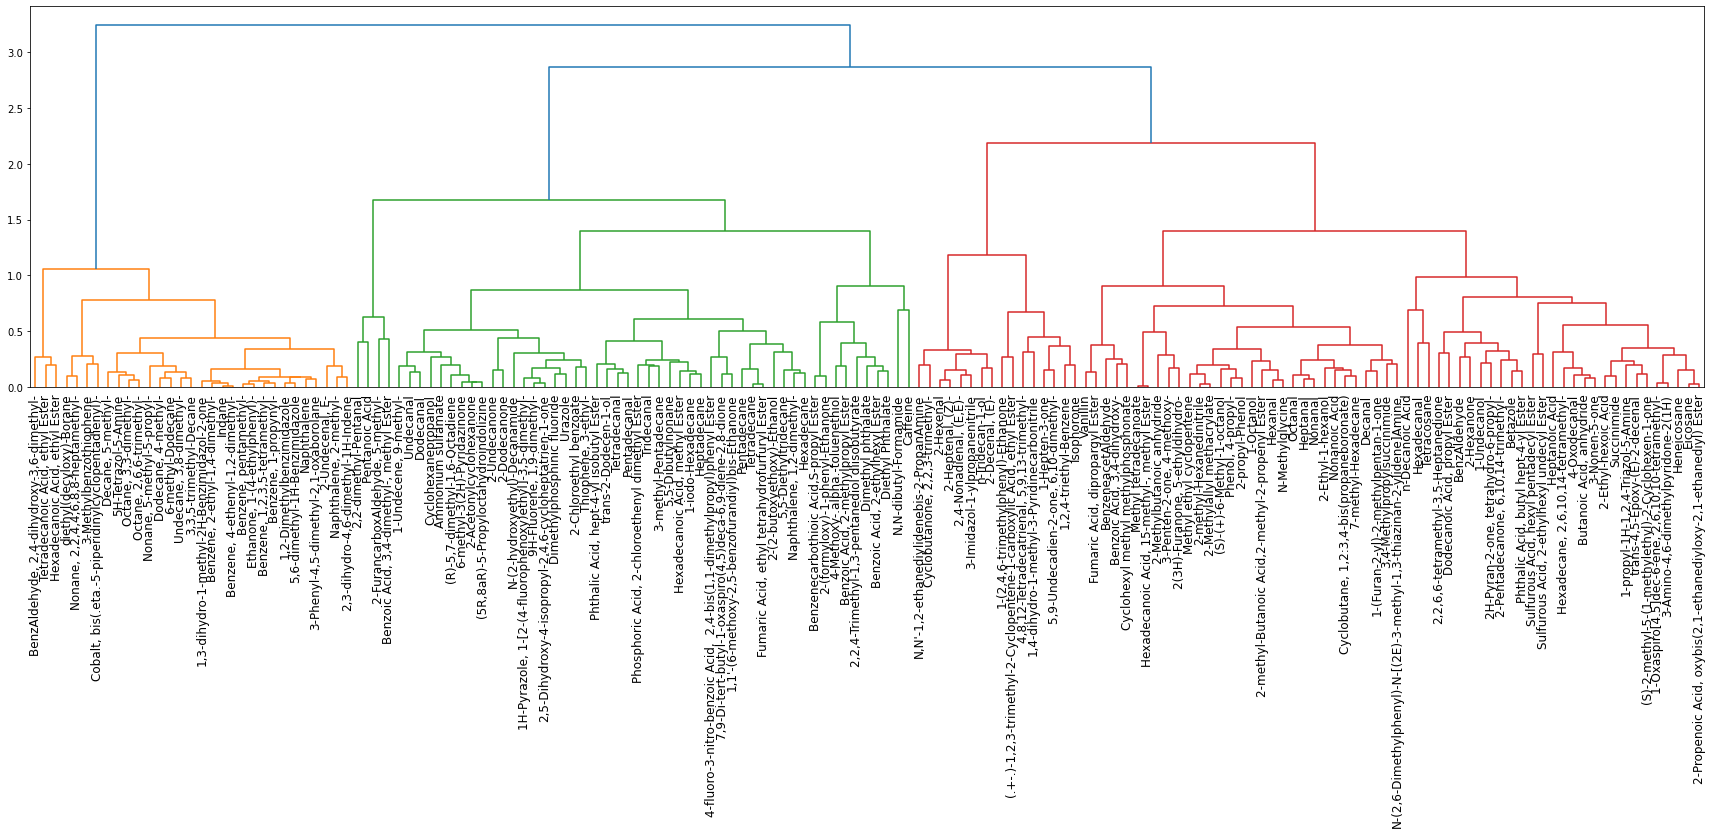

In [18]:
savepath = wd + "代谢成分聚类正则_无删减.pdf"
plot_dend(do_n,savepath)

In [19]:
do_nt = do_n.T

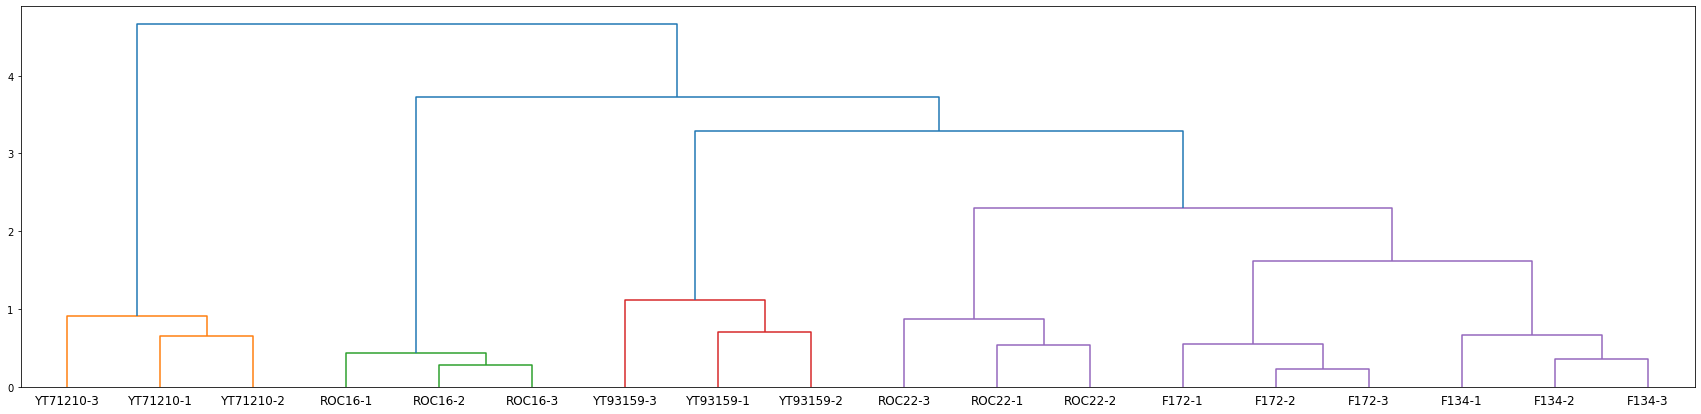

In [21]:
savepath = wd + "样本聚类正则_无删减.pdf"
plot_dend(do_nt,savepath)

## 5 获得聚类类别编号

In [22]:
def data_normlized_get_cluster(data_normalized,n_clusters):
    """
    得到聚类结果
    data_normlized：正则化后的 df, index 是 sample，列是变量/性状
    n_clusters：想要聚成几类，数字
    """ 
    from sklearn.cluster import AgglomerativeClustering
    cluster = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward',affinity='euclidean')  
    cluster_res = cluster.fit_predict(data_normalized)
    
    data_cluster = pd.DataFrame()
    data_cluster.index = data_normalized.index
    data_cluster["cluster"] = cluster_res
    data_cluster["cluster"] = data_cluster["cluster"] + 1
    
    return data_cluster

In [23]:
do_c = data_normlized_get_cluster(do_n,3)
do_c.head(2)

,cluster
Compounds,
5H-Tetrazol-5-Amine,2
"N,N'-1,2-ethanediylidenebis-2-PropanAmine",1


## 6 形成带聚类类别的映射表

In [24]:
do_c = do_c.reset_index()
do_c.head(2)

,Compounds,cluster
0,5H-Tetrazol-5-Amine,2
1,"N,N'-1,2-ethanediylidenebis-2-PropanAmine",1


In [25]:
do_cmap = pd.merge(do_c,dmap)
do_cmap.head(2)

,Compounds,cluster,Class,物质分类
0,5H-Tetrazol-5-Amine,2,Amine,胺
1,"N,N'-1,2-ethanediylidenebis-2-PropanAmine",1,Amine,胺


In [26]:
do_cmap = do_cmap.set_index('Compounds')
do_cmap.head(2)

,cluster,Class,物质分类
Compounds,,,
5H-Tetrazol-5-Amine,2,Amine,胺
"N,N'-1,2-ethanediylidenebis-2-PropanAmine",1,Amine,胺


In [27]:
do_cmap.shape

(161, 3)

## 7 画聚类热力图，数据为正则化后的数据，颜色条来自映射表

In [36]:
def row_colors_dict(item):
    lut = dict(zip(item.unique(), sns.hls_palette(len(set(item)), l=0.5, s=0.8)))
    row_colors = item.map(lut)
    return lut,row_colors

In [37]:
clusters = do_cmap['cluster']
classes = do_cmap['Class']

In [38]:
lut1,rc1 = row_colors_dict(clusters)
lut2,rc2 = row_colors_dict(classes)

In [39]:
row_colors = pd.concat([rc1,rc2],axis=1)

In [40]:
row_colors.head(2)

,cluster,Class
Compounds,,
5H-Tetrazol-5-Amine,"(0.9, 0.14799999999999996, 0.09999999999999998)","(0.9, 0.14799999999999996, 0.09999999999999998)"
"N,N'-1,2-ethanediylidenebis-2-PropanAmine","(0.09999999999999998, 0.9, 0.14800000000000002)","(0.9, 0.14799999999999996, 0.09999999999999998)"


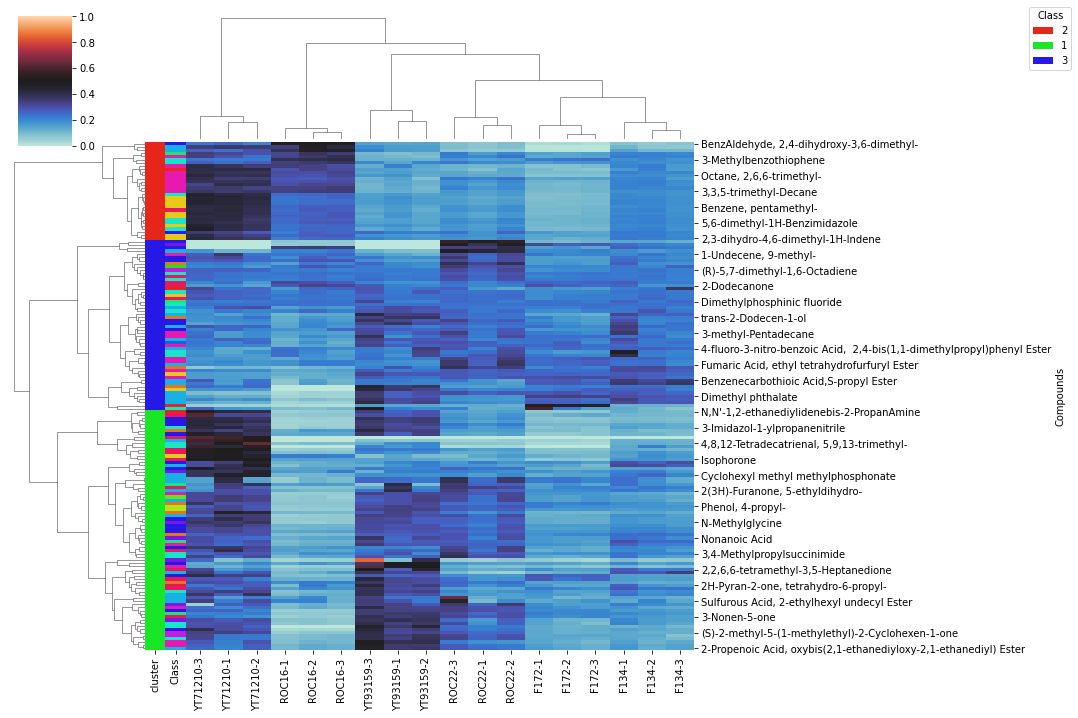

In [41]:
# https://stackoverflow.com/questions/48173798/additional-row-colors-in-seaborn-cluster-map
# 两个调色盘，两列 row_colors
# 注意：row_colors 所在的列要以样本名为 index，比如在同一个 df 里，样本名为 index, row_colors 对应的列为 col

sns.clustermap(
    do_n,
    figsize=(15, 10),metric="euclidean", method="ward",
    center=0.5,vmin=0,vmax=1,
    row_colors=row_colors,
)

from matplotlib.patches import Patch
handles = [Patch(facecolor=lut1[name]) for name in lut1]
plt.legend(handles, lut1, title='Class',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

savepath = wd + '正则聚类热力图100.pdf'
plt.savefig(savepath,bbox_inches = 'tight')

## 8 映射表排序

In [42]:
do_cmap_sort = do_cmap.sort_values(['cluster','Class'])
do_cmap_sort.head()

,cluster,Class,物质分类
Compounds,,,
Nonanoic Acid,1,Acid,酸
n-Decanoic Acid,1,Acid,酸
Heptanoic Acid,1,Acid,酸
2-Ethyl-hexoic Acid,1,Acid,酸
"Benzoic Acid, 3,4-dihydroxy-",1,Acid,酸


In [43]:
savepath = wd + "filename.xlsx"
sheet_name = "聚类结果"
write2excel(do_cmap_sort,savepath,sheet_name)